In [3]:
import os
import sys

# notebook's parent directory path
module_path = os.path.abspath('..')

# add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# Intro to NTS Schedules as Graphs

Provided example uses toy data. You can access the real [UK travel survey from 2002-2021](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340) from the [UK Data Service](https://beta.ukdataservice.ac.uk).

In [4]:
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt

from ntsx import nts_to_nx as core
from ntsx import graph_ops as ops
from ntsx import read_nts
from ntsx.plot import plot
from ntsx.encoders.trip_encoder import TripEncoder
from ntsx.encoders.table_encoder import TableTokeniser

## Load NTS Data

In [5]:
# load dummy data (synthesised from UK NTS)

dir = Path("data/dummyNTS/")
trips_path = dir / "trips.tab"
attributes_path = dir / "individuals.tab"
hhs_path = dir / "households.tab"

years = [2021]

write_dir = Path("tmp")
write_dir.mkdir(exist_ok=True)

In [6]:
trips, labels = read_nts.load_nts(
    trips_path, attributes_path, hhs_path, years=years
)
trips.head(10)

HIDs in people and households do not match, attempting to fix...
Fixed: People 6 -> 7, HHs 5 -> 5


,tid,year,day,iid,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,did,pid
0,1,2021,2,1,1,1,car,home,social,0.989618,675,683,7,7,0,1_1
1,2,2021,2,1,1,2,car,social,other,1.002945,720,735,7,7,0,1_1
2,3,2021,2,1,1,3,car,other,social,0.989618,770,780,7,7,0,1_1
3,4,2021,2,1,1,4,taxi,social,home,0.989618,1110,1130,7,7,0,1_1
4,5,2021,3,1,1,1,car,home,social,0.999891,760,770,7,7,1,1_1
5,6,2021,3,1,1,2,car,social,social,0.999891,790,805,7,7,1,1_1
6,7,2021,3,1,1,3,car,social,other,1.061665,810,825,7,7,1,1_1
7,8,2021,3,1,1,4,car,other,other,1.061665,845,852,7,7,1,1_1
8,9,2021,3,1,1,5,car,other,social,0.999891,865,873,7,7,1,1_1
9,10,2021,3,1,1,6,car,social,escort,1.006313,908,914,7,7,1,1_1


## Labels/Attributes Encoding

In [7]:
# first map labels to readable values
labels = read_nts.label_mapping(labels)
display(labels.head())

# then as multiple categorical values
# initiate label encoder
label_encoder = TableTokeniser(labels, verbose=False)
# encode labels
labels_encoded = label_encoder.encode(labels)
display(labels_encoded[0:10])

,hid,age,gender,ethnicity,education,license,car_access,work_status,year,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles
iid,,,,,,,,,,,,,,,,,
1,2002003369,70+,F,white,unknown,yes,yes,unemployed,2021,suburban,1,1,1adult,2,1,1,0
2,2002003370,50-70,F,white,unknown,no,no,employed,2021,suburban,1,2,1adult,2,1,1,1
3,2002003371,70+,F,white,unknown,no,yes,unemployed,2021,suburban,1,2,1adult,2,1,1,2
4,2002003371,70+,M,white,unknown,yes,yes,unemployed,2021,suburban,1,2,1adult,2,1,1,2
5,2002003372,40-50,M,white,unknown,yes,yes,employed,2021,suburban,1,1,1adult,2,1,1,0


tensor([[2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
        [2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2],
        [2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
# label encoder can then be used to re-encode more data or decode in future as required
# decode
labels_decoded = label_encoder.decode(labels_encoded)
display(labels_decoded.head())

,pid,age,gender,ethnicity,education,license,car_access,work_status,year,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles
0,0,70+,F,white,unknown,yes,yes,unemployed,2021,suburban,1,1,1adult,2,1,1,0
1,1,50-70,F,white,unknown,no,no,employed,2021,suburban,1,2,1adult,2,1,1,1
2,2,70+,F,white,unknown,no,yes,unemployed,2021,suburban,1,2,1adult,2,1,1,2
3,3,70+,M,white,unknown,yes,yes,unemployed,2021,suburban,1,2,1adult,2,1,1,2
4,4,40-50,M,white,unknown,yes,yes,employed,2021,suburban,1,1,1adult,2,1,1,0


## Trips Graph Encoding

In [9]:
# initiate encoders for trip features
trip_encoder = TripEncoder(
    trips
)  # currently needs to be initialised from trips table

# can be used to encode trips table
trips_encoded = trip_encoder.encode_trips_table(trips)
display(trips_encoded.head())

0        car
1        car
2        car
3       taxi
4        car
       ...  
144      car
145      car
146      car
147    train
148    train
Name: mode, Length: 149, dtype: object
0        home
1      social
2       other
3      social
4        home
        ...  
144      shop
145      home
146    social
147      home
148      work
Name: oact, Length: 149, dtype: object
0      social
1       other
2      social
3        home
4      social
        ...  
144      home
145    social
146      home
147      work
148      home
Name: dact, Length: 149, dtype: object
0       2
1       2
2       2
3       2
4       3
       ..
144    47
145    47
146    47
147    49
148    49
Name: day, Length: 149, dtype: int64
0       675
1       720
2       770
3      1110
4       760
       ... 
144     900
145    1013
146    1306
147     495
148    1052
Name: tst, Length: 149, dtype: int64
0       683
1       735
2       780
3      1130
4       770
       ... 
144     906
145    1023
146    1312
147     

,tid,year,day,iid,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,did,pid
0,1,2021,0,1,1,1,1,2,7,0.989618,0.468750,0.474306,0,0,0,1_1
1,2,2021,0,1,1,2,1,7,5,1.002945,0.500000,0.510417,0,0,0,1_1
2,3,2021,0,1,1,3,1,5,7,0.989618,0.534722,0.541667,0,0,0,1_1
3,4,2021,0,1,1,4,2,7,2,0.989618,0.770833,0.784722,0,0,0,1_1
4,5,2021,1,1,1,1,1,2,7,0.999891,0.527778,0.534722,0,0,1,1_1


In [10]:
# or for individual features
display(trip_encoder.encode("bus", name="mode"))
display(trip_encoder.encode(1220, name="tst"))
# decoding...
display(trip_encoder.decode(2, "mode"))

0

0.8472222089767456

'taxi'

In [11]:
# for iterables more generally (as we might have in a graph)
display(trip_encoder.encode_iterable(["walk", "train"], "mode"))
display(trip_encoder.decode_iterable([0.5, 0.6], "tst"))

tensor([4, 3], dtype=torch.int32)

0    720
1    864
dtype: int64

## Building an Individual Graph

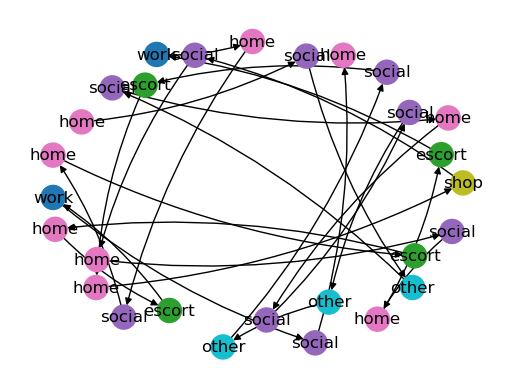

In [12]:
# load  the first persons trips into nx
iid = 1
g = core.to_nx(trips.loc[trips.iid == iid])
plot(g, k=5)

Could not find any education activities.


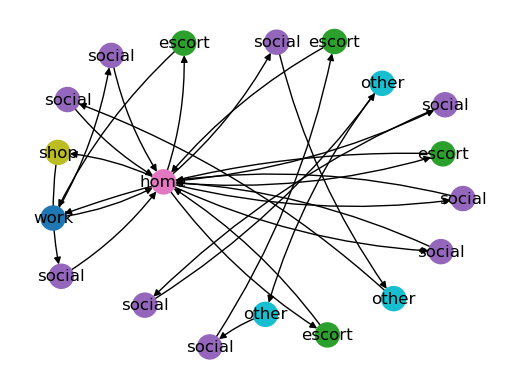

In [13]:
# nodes/vertices represent facilities for activities (they have a type eg "work" and an approx location)
# edges represent trips between activities (they have a mode eg "car", a start time and a duration)
# first we combine facilities (nodes) based on a given list of "anchor" activities

g_anchored = ops.anchor_activities(g, ["home", "work", "education"])
plot(g_anchored, k=5)

Contacting; 26 and 19
Contacting; 7 and 17
Contacting; 7 and 28


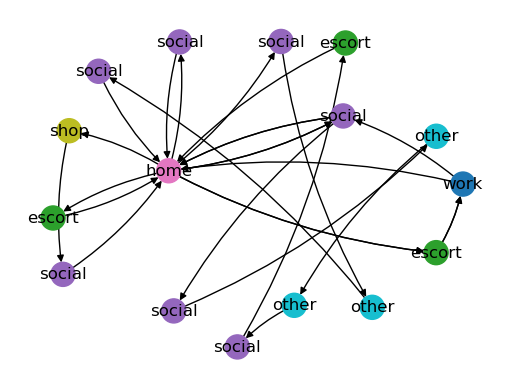

In [14]:
# now we merge similar looking facilities beyond the anchors
# we do this by iteratively searching facilities breadth first from the home facility
# for each facility we condider all pairs of trips (in and out)
# if the trips are similar and come from similar looking facilities we merge the facilities
# Facility similarity is based on a facility having the same activity type and zone
# Trip similarity is based on the trip mode being the same and the durations being within tolerance

merged_g = ops.merge_similar(g_anchored, duration_tolerance=0.2, verbose=True)
plot(merged_g, k=5)

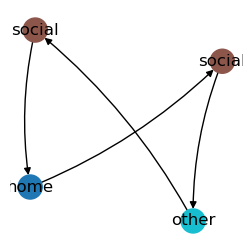

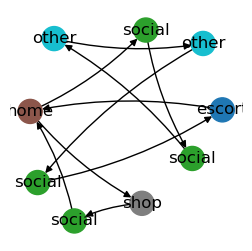

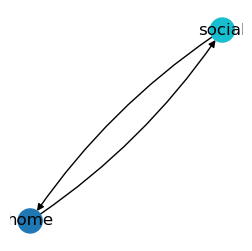

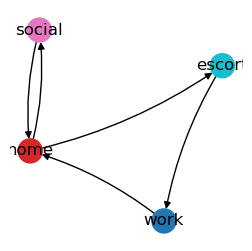

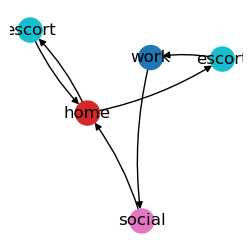

In [15]:
# We can split the graph back into days:
for day, g in ops.iter_days(merged_g):
    plot(g, figsize=(3, 3), k=5)

## Masking

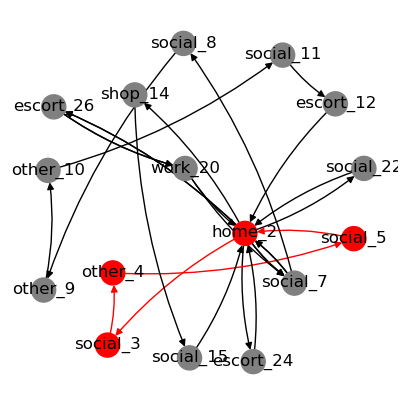

In [16]:
# we can also create a boolean mask for edges
# in this case we demo a mask for each day

positions = nx.spring_layout(merged_g, weight="duration", seed=12345, k=5)
acts = {i: f"{node.get("act")}_{i}" for i, node in merged_g.nodes(data=True)}

for day, g in ops.iter_days_masked(merged_g):
    masked_edges = [
        (u, v, k) for u, v, k in g.edges(keys=True) if g[u][v][k].get("masked")
    ]
    masked_nodes = set([u for u, _, _ in masked_edges]) | set(
        [v for _, v, _ in masked_edges]
    )
    edge_colors = [
        "red" if g[u][v][k].get("masked") else "black"
        for u, v, k in g.edges(keys=True)
    ]
    node_colors = ["red" if n in masked_nodes else "grey" for n in g.nodes]

    fig, ax = plt.subplots(figsize=(5, 5))
    nx.draw(
        g,
        positions,
        labels=acts,
        with_labels=True,
        connectionstyle="arc3,rad=0.1",
        ax=ax,
        edge_color=edge_colors,
        node_color=node_colors,
    )
    break

## Multiple People

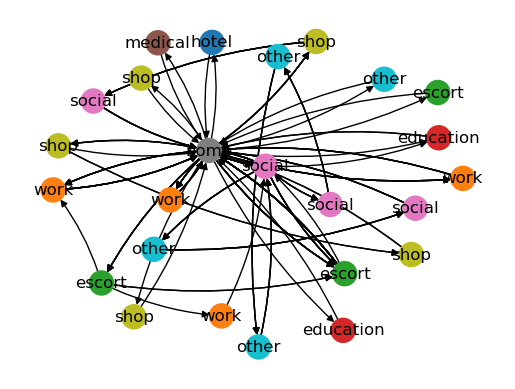

In [17]:
# we can repeat above for multiple persons
# load in first 1000 trips and combine them into a single graph

gs = core.to_nx(trips.head(1000))
gs = ops.anchor_activities(gs, ["home"])
gs = ops.merge_similar(gs, duration_tolerance=0.2)
plot(gs, k=5)